In [1]:
from datasets import load_dataset
import os
# import pytorch_lightning as py
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch
import pandas as pd
import gzip
# import glob
import tarfile
from PIL import Image
import io
from scipy.io import loadmat 
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import numpy as np
from torchvision import transforms
import torch.nn as nn

In [2]:
if torch.cuda.is_available():
    print(f"running cuda on device: {torch.cuda.current_device()}")
    device = torch.device("cuda")    
else:
    print(f"no cuda device found")
    device = torch.device("cpu")    


running cuda on device: 0


In [3]:
class DepthDataSet(data.Dataset):
    def __init__(self, path, depth=False):
        # self.files = glob.glob(f"{path}/*.tar.gz")
        self.paths = path
        self.path_file_map = []
        self.data = []
        self.files = os.listdir(path)
        self.labels = []
        self.depth = depth

        # print(self.files)
        for file in self.files:
            # with tarfile.open(file, 'r') as f:
                # data = pd.read_csv(f)
            with tarfile.open(f'{path}/{file}','r:gz') as f:
                for member in f.getmembers():
                    if f.extractfile(member):    
                        self.data.append(member)
                        # print(member)
                        label = os.path.basename(os.path.dirname(member.name))
                        # print(label)
                        
                        #map the label of the image to the correct file
                        self.labels.append(label)
                        self.path_file_map.append(file)


        # self.label_to_index = {label: i for i, label in enumerate(sorted(set(self.labels)))}

                # print(f.extractall())
                # t_file = f.ex
                # for tarfile in f.extractall():
                    # print(tarfile)
                # self.data.extend([img for img in f.getmembers()])
                # data = pd.read_csv(f.extractall,compression='gzip', header=0, sep=' ', quotechar='"', encoding=bytes)    
                # self.data.append(data)
        
        # self.data = pd.concat(self.data)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        path = self.path_file_map[index]
        # print('path =',path)

        # path = "Train400Img.tar.gz" if self.labels[index] == "" else self.labels[index]

        # print('data =',self.data[index])
        
        with tarfile.open(f'{self.paths}/{path}', 'r:gz') as tf:
            file = tf.extractfile(self.data[index])
            
            # image = tf.getmember(self.data[index])
            if(self.depth == False):
                img = Image.open(io.BytesIO(file.read()))
                toTensor = transforms.ToTensor()
                img = toTensor(img)
            # label = self.label_to_index[self.labels[index]]
                # if(torch.cuda.is_available()):
                #     img = img.to('cuda')
                # print(img)
                return img
        
            else:
                img = loadmat(io.BytesIO(file.read()))
                # matObj = plt.mat    
                # print(img)

                img = img.get("Position3DGrid")
                
                depth = img[:,:,3]
                depth = np.log1p(depth)

                target = (1704,2272)

                depth_resized = cv.resize(depth, target, interpolation=cv.INTER_CUBIC)
                depth_resized = cv.normalize(depth_resized, None, 0, 255, cv.NORM_MINMAX)
                depth_resized = depth_resized.astype(np.uint8)

                depth_resized = np.expand_dims(depth_resized,axis=2)

                depth_resized = torch.from_numpy(depth_resized).permute(2,0,1).float() / 255.0

                # if(torch.cuda.is_available()):
                #     depth_resized = depth_resized.to('cuda')
                
                # print(depth_resized)

                # depth = img[:,:,3]
                # max_depth = depth.max()
                # depth = Image.fromarray(depth.astype(np.float32))
                # print(depth)

                # # print(depth)
                # depth = depth/max_depth
                
                # print(depth)

                # depth = depth.resize((2272,1704))
                # print(img)
                # print(img[:,:,2])
                return depth_resized

In [4]:
train_img_dataset = DepthDataSet(path='./data/train/imgs')

In [5]:
train_depth_dataset = DepthDataSet(path='./data/train/depths',depth=True)

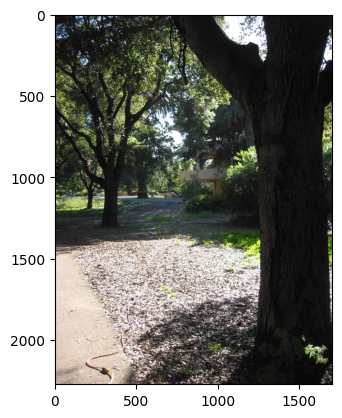

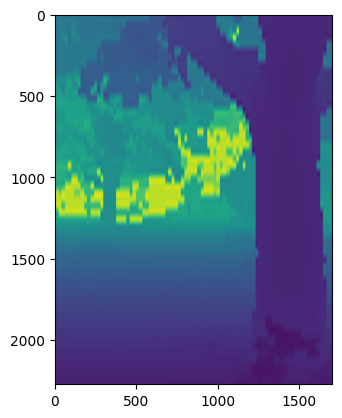

In [6]:
index=193
image = train_img_dataset[index]
image = image.cpu().permute(1,2,0).numpy()
plt.imshow(image)
plt.show()

depth_map = train_depth_dataset[index]
depth_map = depth_map.cpu().permute(1,2,0).numpy()
plt.imshow(depth_map)
plt.show()

In [43]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()

        #(2272, 1704, 3) -> (2272, 1704, 16)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=5,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        

        #(568, 426, 32) -> (568, 426, 64)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )


        #(284, 213, 64) -> (95, 71, 32)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3,stride=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        #flatten

        self.fully_c1 = nn.Sequential(
            nn.Linear(51*38*16,25*16*8),
            nn.ReLU(inplace=True)
        )
        self.fully_c2 = nn.Sequential(
            nn.Linear(25*16*8, 10*8*4)
        )
        # self.fully_c3 = nn.Linear(20*16*8, 5*4*2)

    def forward(self, x):
        # print("{:20s} {}".format("Input Shape:",np.shape(x)))

        x = self.conv1(x)
        # print("{:20s} {}".format("Conv1:",np.shape(x)))

        x = self.conv2(x)
        # print("{:20s} {}".format("Conv2:",np.shape(x)))

        x = self.conv3(x)
        # print("{:20s} {}".format("Conv3:",np.shape(x)))

        x = x.flatten(1)
        # print("{:20s} {}".format("Flatten:",np.shape(x)))

        x = self.fully_c1(x)
        # print("{:20s} {}".format("Fully Conn L1:",np.shape(x)))

        x = self.fully_c2(x)
        # print("{:20s} {}".format("Fully Conn L2:",np.shape(x)))

        # x = self.fully_c3(x)
        # print("{:20s} {}".format("Fully Connected Layer 3:",np.shape(x)))
        return x


In [44]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        self.fully_c2 = nn.Sequential(
            nn.Linear(10*8*4,25*16*8)
        )

        self.fully_c1 = nn.Sequential(
            nn.Linear(25*16*8,51*38*16),
            nn.ReLU(inplace=True)
        )

        #unflatten
        self.unflatten = nn.Unflatten(1,(16,51,38))

        #(284, 213, 64) -> (95, 71, 32)
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16,out_channels=32,kernel_size=3,stride=3,padding=1),
            nn.AdaptiveAvgPool2d((152,114)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        #(568, 426, 32) -> (568, 426, 64)
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=3,stride=3,padding=0),
            nn.AdaptiveAvgPool2d((455,341)),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        #(2272, 1704, 3) -> (2272, 1704, 16)
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16,out_channels=1,kernel_size=5,stride=5,padding=0),
            nn.AdaptiveAvgPool2d((2272,1704)),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True)
        )
        

    def forward(self, x):
        # print("{:20s} {}".format("Input Shape:",np.shape(x)))
        
        x = self.fully_c2(x)
        # print("{:20s} {}".format("Fully Conn L2:",np.shape(x)))
        
        x = self.fully_c1(x)
        # print("{:20s} {}".format("Fully Conn L1:",np.shape(x)))

        x = self.unflatten(x)
        # print("{:20s} {}".format("Unflatten:",np.shape(x)))

        x = self.conv3(x)
        # print("{:20s} {}".format("Conv3:",np.shape(x)))

        x = self.conv2(x)
        # print("{:20s} {}".format("Conv2:",np.shape(x)))

        x = self.conv1(x)
        # print("{:20s} {}".format("Conv1:",np.shape(x)))

        #map values 0 to 1
        x = torch.sigmoid(x)

        # x = self.fully_c3(x)
        # print("{:20s} {}".format("Fully Connected Layer 3:",np.shape(x)))
        return x


In [57]:
encoder = Encoder()
encoder = encoder.to(device)

In [60]:
decoder = Decoder()
decoder = decoder.to(device)

In [61]:
img_dataloader = DataLoader(train_img_dataset,batch_size=8,shuffle=True)
depth_dataloader = DataLoader(train_depth_dataset,batch_size=8,shuffle=True)

In [63]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8,gamma=0.1)

In [64]:
def train(encoder,decoder,img_dataloader,depth_dataloader,optimizer,loss, scheduler, epochs=2):
    encoder.train()
    decoder.train()

    for epoch in range(epochs):
        total_loss = 0.0
        batch_num = 0
        for data,depth_data in zip(img_dataloader,depth_dataloader):

            batch_num+=1
            
            inputs = data
            ground_truth = depth_data

            inputs = inputs.to(device)
            ground_truth = ground_truth.to(device)

            optimizer.zero_grad()

            encoded = encoder(inputs)
            decoded = decoder(encoded)

            loss_val = loss(decoded,ground_truth)

            loss_val.backward()

            optimizer.step()
            
            curr_loss = loss_val.item()
            total_loss+= curr_loss
            print("Batch:{:3d}/{:3d}{:10}Loss{:10f}".format(batch_num,len(img_dataloader),"",curr_loss))
        scheduler.step()
        print("Epoch {:10d}{:10}Loss:{:10f}".format(epoch,"",total_loss/len(img_dataloader)))            

In [ ]:
train(encoder,decoder,img_dataloader,depth_dataloader,optimizer,loss,scheduler,epochs=20)

Batch:  1/ 50          Loss  0.123164
Batch:  2/ 50          Loss  0.101650
Batch:  3/ 50          Loss  0.105889
Batch:  4/ 50          Loss  0.107975
Batch:  5/ 50          Loss  0.103311
Batch:  6/ 50          Loss  0.097581
Batch:  7/ 50          Loss  0.079923
Batch:  8/ 50          Loss  0.081721
Batch:  9/ 50          Loss  0.096309
Batch: 10/ 50          Loss  0.100484
Batch: 11/ 50          Loss  0.085041
Batch: 12/ 50          Loss  0.091423
Batch: 13/ 50          Loss  0.088471
Batch: 14/ 50          Loss  0.092635
Batch: 15/ 50          Loss  0.084223
Batch: 16/ 50          Loss  0.078923
Batch: 17/ 50          Loss  0.104443
Batch: 18/ 50          Loss  0.088254
Batch: 19/ 50          Loss  0.083565
Batch: 20/ 50          Loss  0.071666
Batch: 21/ 50          Loss  0.085633
Batch: 22/ 50          Loss  0.085760
Batch: 23/ 50          Loss  0.081401
Batch: 24/ 50          Loss  0.079411
Batch: 25/ 50          Loss  0.091391
Batch: 26/ 50          Loss  0.077011
Batch: 27/ 5

KeyboardInterrupt: 

In [39]:
torch.save(encoder.state_dict(),"./models/saved/encoder.pth")
torch.save(decoder.state_dict(),'./models/saved/decoder.pth')

In [40]:
encoder.eval()
decoder.eval()

Decoder(
  (fully_c2): Sequential(
    (0): Linear(in_features=320, out_features=3200, bias=True)
  )
  (fully_c1): Sequential(
    (0): Linear(in_features=3200, out_features=31008, bias=True)
    (1): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(16, 51, 38))
  (conv3): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): AdaptiveAvgPool2d(output_size=(152, 114))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(3, 3))
    (1): AdaptiveAvgPool2d(output_size=(455, 341))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (conv1): Sequential(
    (0): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(5, 5))
    (1): AdaptiveAvgPool2d(output_size=(2272, 1704))
    (2): BatchNorm2d(1, eps

In [41]:
imgs = next(iter(img_dataloader))

encoded_imgs = encoder(imgs.to(device))
decoded_imgs = decoder(encoded_imgs)

# for i in range(decoded_imgs.shape)

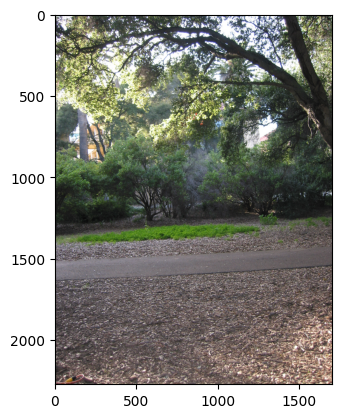

mean:127.00000180809033
var:2.324684292801059e-06
max:129


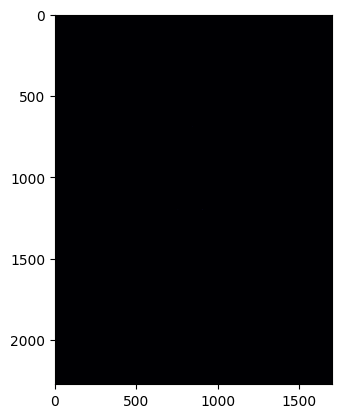

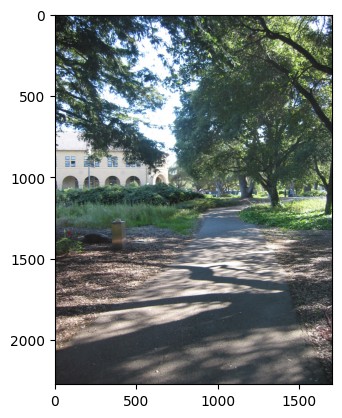

mean:127.0000201472922
var:4.1843970202466576e-05
max:130


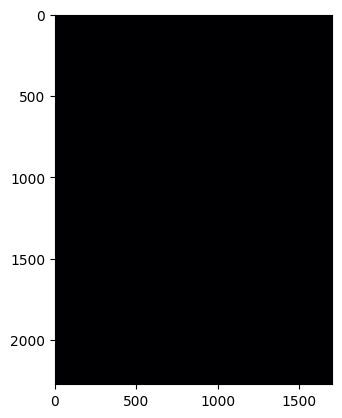

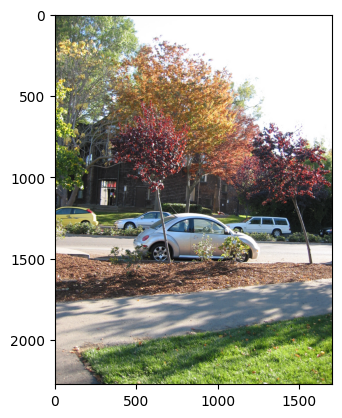

mean:127.00000051659724
var:5.165969691254427e-07
max:128


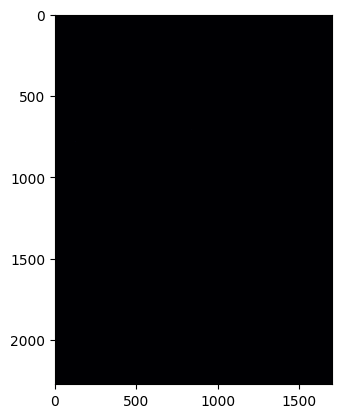

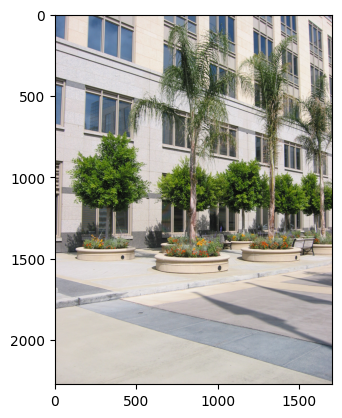

mean:127.00000258298618
var:3.099576744171279e-06
max:129


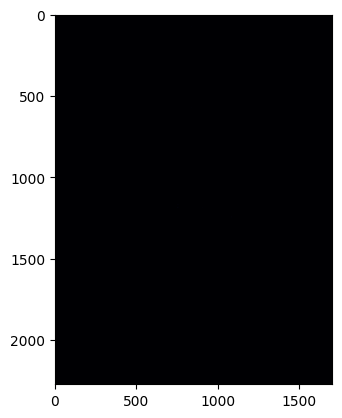

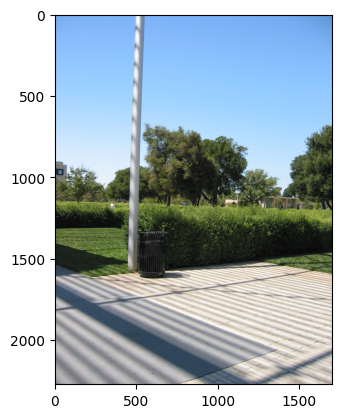

mean:127.00001911409773
var:4.236060800311553e-05
max:130


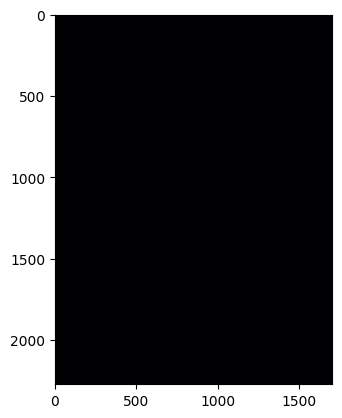

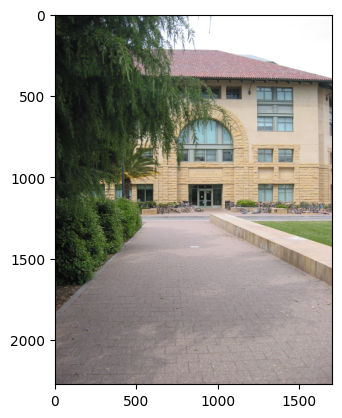

mean:127.00000180809033
var:2.3246842928010587e-06
max:129


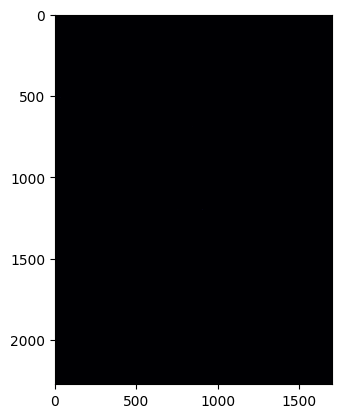

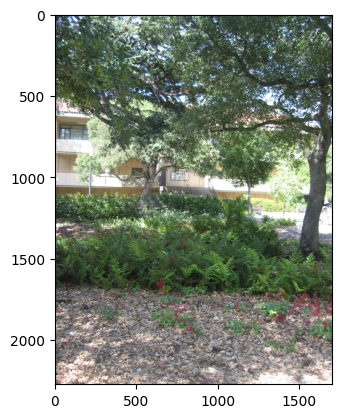

mean:127.00001368982676
var:2.6604570242548376e-05
max:131


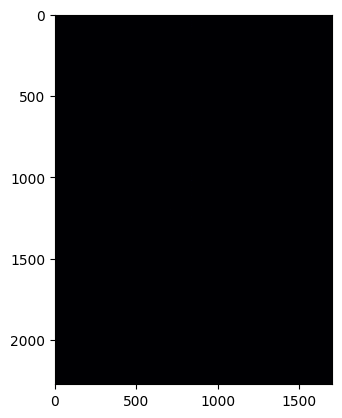

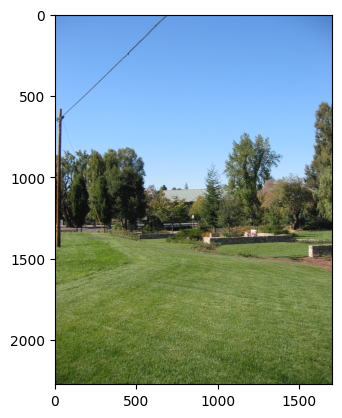

mean:127.0000015497917
var:2.5829837781364e-06
max:129


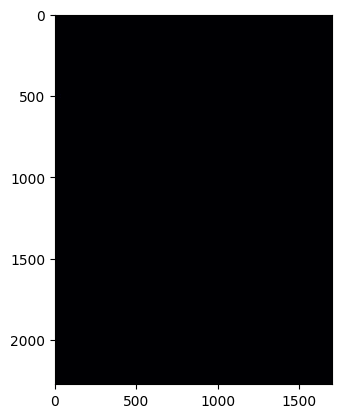

In [42]:
decoded_imgs = decoded_imgs.to("cpu")
decoded_imgs = decoded_imgs.detach()
for i in range(decoded_imgs.shape[0]):
    plt.imshow(imgs[i].permute(1,2,0))
    plt.show()
    depth = np.array(decoded_imgs[i].permute(1,2,0)*255,dtype=np.uint8)
    print(f"mean:{np.mean(depth)}\nvar:{np.var(depth)}\nmax:{np.max(depth)}")
    plt.imshow(depth,cmap='magma')
    plt.show()